In [2]:
import math
import matplotlib.pyplot as plt
from graphviz import Digraph

In [90]:

class Value:
    def __init__(self, data, children = (), _op = "", label = ""):
        self.data = data
        self.children = children
        self._op = _op
        self._prev = set(children)
        self._backward = lambda:None 
        self.grad = 0
        self.label = label

    def has_children(self):
        return True if len(self._prev) > 0 else False

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        print(out.children)

        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = _backward
        return out


    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def chain_rule(self):
        stack = []
        visited = set()
        def topological_sort(root):
            if root in visited: return

            visited.add(root)
            for child in root._prev:
                topological_sort(child)
            stack.append(root)

        topological_sort(self)
        
        #With the topological sort, we can now calculate the gradients in full:
        self.grad = 1
        good_order = stack[::-1]
        for node in good_order:
            node._backward()




    def __repr__(self):
        return f"Value {self.data}"





example of how this should work: 

Value (5.0) + Value(4.0) = Value(9.0), where the operand used was a "+"

In [91]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ data %.4f }" % (n.data,), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot



(Value 5.0, Value 4.0)
None



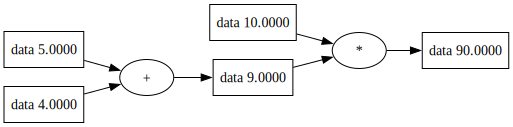

In [ ]:
x = Value(5.0); label = "x"
y = Value(4.0) ; label = "y"
d = Value(10.0); label = "d"

print(x.label)


z = x + y ; label = "z"
l = d * z ; label  = "l"

print(l.chain_rule())

print(l.label)

trace(l)

draw_dot(l)


Now, the goal is to try and implement gradients and backpropagation using those gradients:

What we know: 

if c = a + b, then dc / da = dc / db = 1
if c = a * b, then dc / da = b, and dc / da = c

Thus we can implement a gradient implementation for this.


Workflow: I first start with the gradient of the first node. Afterwards, I have use the gradient of the children to then find the gradient with respect to the parents. Finally, I can multiply every gradient to get everything with respect to the parent.